In [101]:
# library imports
import itertools
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
# view cleaned dataset
pd.read_csv('Resources/Data/steam_cleaned.csv').head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [103]:
def remove_non_english(df):

    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()
    
    # remove english column, now redundant
    df = df.drop('english', axis=1)
    
    return df

def calc_rating(row):

    # https://steamdb.info/blog/steamdb-rating/

    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def process_cat_gen_tag(df):
    
    # only going to use these categories
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()

    # remove redundant columns
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df

# preprocess for exploratory analysis
def pre_process():
    
    # read in cleaned dataset
    df = pd.read_csv('Resources/Data/steam_cleaned.csv')
    
    # keep english only
    df = remove_non_english(df)
    
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    
    # calculate rating, along w/ simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to dt type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # process genres and categories
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process()
data.head()

,appid,name,release_date,developer,publisher,required_age,genres,achievements,positive_ratings,negative_ratings,...,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,Action,0,124534,3339,...,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,Action,0,3318,633,...,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,Action,0,3416,398,...,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,Action,0,1273,267,...,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,Action,0,5250,288,...,1,0,0,0,0,0,0,0,0,0


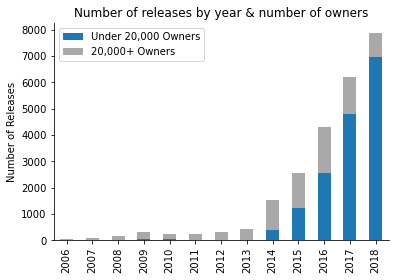

In [105]:
df = data.copy()

years = []
lt_20k = []
gt_20k = []

# very few releases in data prior to 2006, and data is from 2019
for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.owners < 20000].shape[0]
    total_gt_20k = year_df[year_df.owners >= 20000].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], 
                    kind='bar', 
                    stacked=True, 
                    color=['tab:blue', 'darkgrey']
                   )

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year & number of owners')
sns.despine()
plt.show()

In [106]:
display_cols = ['name', 'developer', 'publisher', 'genres', 'release_year', 'average_playtime', 'owners', 'rating', 'price']
top_ten = df.sort_values(by='rating', ascending=False).head(10)

top_ten[display_cols]

,name,developer,publisher,genres,release_year,average_playtime,owners,rating,price
23,Portal 2,Valve,Valve,Action;Adventure,2011,1102,10000000,97.257760,7.19
7577,Factorio,Wube Software LTD.,Wube Software LTD.,Casual;Indie;Simulation;Strategy;Early Access,2016,10087,1000000,96.601391,21.00
2964,The Witcher® 3: Wild Hunt,CD PROJEKT RED,CD PROJEKT RED,RPG,2015,3068,5000000,96.465364,24.99
17,Portal,Valve,Valve,Action,2007,288,10000000,96.103502,7.19
0,Counter-Strike,Valve,Valve,Action,2000,17612,10000000,95.975678,7.19
1120,Terraria,Re-Logic,Re-Logic,Action;Adventure;Indie;RPG,2011,5585,5000000,95.907030,6.99
1962,The Binding of Isaac: Rebirth,"Nicalis, Inc.","Nicalis, Inc.",Action,2014,4583,2000000,95.871763,10.99
3036,RimWorld,Ludeon Studios,Ludeon Studios,Indie;Simulation;Strategy,2018,5017,1000000,95.802600,27.79
21,Left 4 Dead 2,Valve,Valve,Action,2009,1615,10000000,95.631142,7.19
1596,Euro Truck Simulator 2,SCS Software,SCS Software,Indie;Simulation,2012,4942,5000000,95.547966,14.99


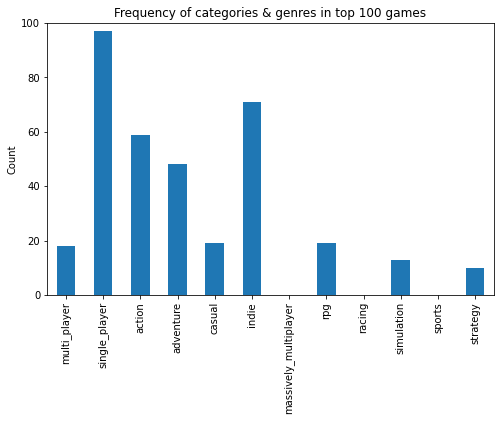

In [107]:
# subset top 100 games and most important features
display_cols = ['name', 'developer', 'publisher', 'genres', 'release_year', 'average_playtime', 'owners', 'rating', 'price']
top_ten = df.sort_values(by='rating', ascending=False).head(100)

# storing category and genre columns back into a variable to easy access
cat_gen_cols = df.columns[-12:]
ax = top_ten[cat_gen_cols].sum().plot.bar(figsize=(8,5))

ax.set_ylim([0, 100])
ax.set_ylabel('Count')
ax.set_title('Frequency of categories & genres in top 100 games')

plt.show()

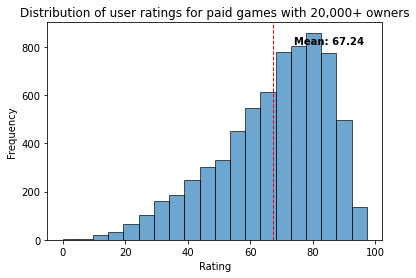

In [108]:
# paid with over 20,000 owners
df = data[(data.owners >= 20000) & (data.price > 0)].copy()

x = df.rating
result = plt.hist(x, bins=20, edgecolor='k', alpha=0.65)

# plot line for mean on histogram
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1)

# include mean in text
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()), weight='bold')

plt.title('Distribution of user ratings for paid games with 20,000+ owners')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

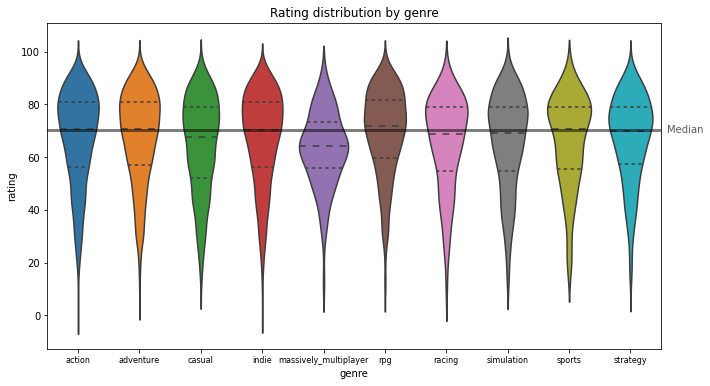

In [109]:
g_df = pd.DataFrame()

gen_cols = cat_gen_cols.drop(['multi_player', 'single_player'])

# create new dataframe with rating and genre, as games can belong to multiple genres
for col in gen_cols:
    ratings = pd.DataFrame(df.loc[df[col] == 1, 'rating'].values, columns=['rating'])
    ratings['genre'] = col
    g_df = pd.concat([g_df, ratings], axis=0)

fig, ax = plt.subplots(figsize=(11,6))
sns.violinplot(x='genre', y='rating', data=g_df, inner='quartile', ax=ax)
ax.axhline(g_df.rating.median(), color='black', lw=3, alpha=.5)
ax.text(9.6, g_df.rating.median()-1, 'Median', color='black', alpha=0.65)

ax.tick_params(axis='x', labelsize=8)
ax.set_title("Rating distribution by genre");
plt.show()

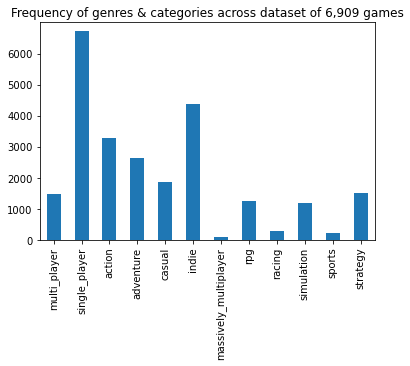

In [112]:
ax = df[cat_gen_cols].sum().plot.bar()
ax.set_ylim([0, 6999])
ax.set_title(f'Frequency of genres & categories across dataset of {df.shape[0]:,} games')

plt.show()

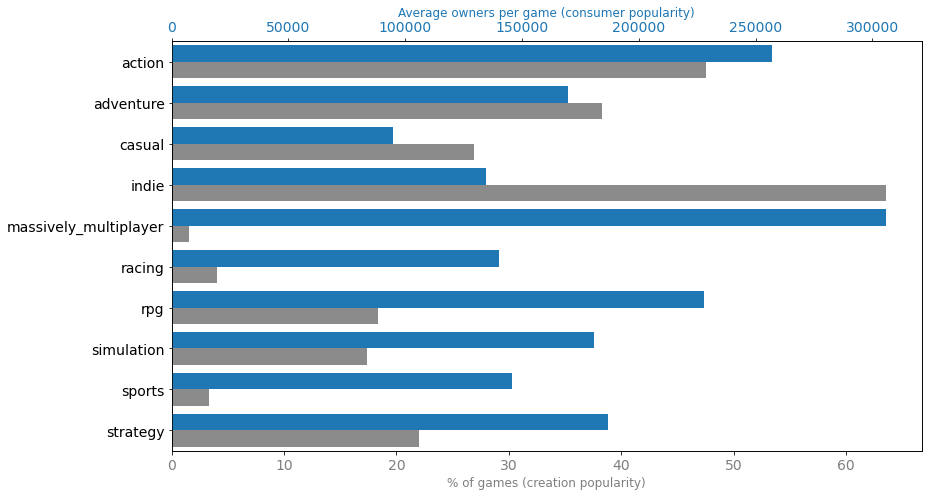

In [125]:
def plot_owners_comparison(df):
    # percentage of games in each genre
    total_owners_per_genre = df[gen_cols].multiply(df['owners'], axis='index').sum()
    average_owners_per_genre = total_owners_per_genre / df[gen_cols].sum()

    fig, ax1 = plt.subplots(figsize=(13,7))

    color = 'tab:gray'
    (df[gen_cols].mean() * 100).sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.9, position=1, fontsize=14, width=0.4)
    # ax1.set_ylabel('genre')

    ax1.set_xlabel('% of games (creation popularity)', color=color, size=12)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.tick_params(axis='y', left='off', top='off')
    # ax1.axes.get_yaxis().set_visible(False)

    ax2 = ax1.twiny()

    color = 'tab:blue'
    average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=1, position=0, fontsize=14, width=0.4)
    ax2.set_xlabel('Average owners per game (consumer popularity)', color=color, size=12)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_ylim([-.5, 9.5])

    plt.tight_layout()
    plt.show()
    
plot_owners_comparison(df[df.owners <= 10000000])

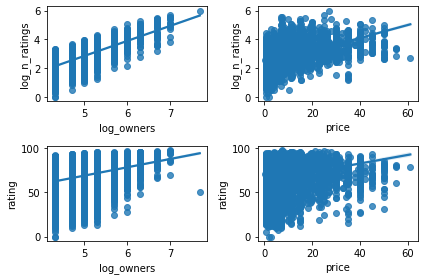

In [124]:
log_df = pd.DataFrame(zip(np.log10(df.owners), np.log10(df.total_ratings), df.rating, df.price),
                      columns=['log_owners', 'log_n_ratings', 'rating', 'price'])

fig, axarr = plt.subplots(2, 2)

sns.regplot(x='log_owners', y='log_n_ratings', data=log_df, ax=axarr[0][0])
sns.regplot(x='log_owners', y='rating', data=log_df, ax=axarr[1][0])
sns.regplot(x='price', y='log_n_ratings', data=log_df, ax=axarr[0][1])
sns.regplot(x='price', y='rating', data=log_df, ax=axarr[1][1])

plt.tight_layout()
plt.show()